### Speeding up eigenportfolios with eigensolver algorithms

In this project, I attempt to do some portfolio selection via eigendecomposition of the covariance matrix of log returns. 
More interestingly, I try to come up with a solution to find the eigenportfolio with maximum abs eigenvalue without needing to diagonalise the entire covariance matrix.
This is done via Power Iteration methods, and is faster than using ```np.linalg.eigh()```, which performs QR Iteration on the entire covariance matrix.


### Data Prep

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import njit

In [127]:
import yfinance as yf

def download() -> None:
    tickers = ["SPY", "QQQ", "GLD", "IEMG", "VEA", "XLF"]
    df = yf.download(tickers, period="5y", interval="1d")["Adj Close"]
    df.to_pickle("data.pickle")

def load() -> pd.DataFrame:
    return pd.read_pickle("data.pickle")

download()

[*********************100%***********************]  6 of 6 completed


In [128]:
df = load()
df.head()

,GLD,IEMG,QQQ,SPY,VEA,XLF
Date,,,,,,
2017-11-30,121.099998,48.627808,149.941849,243.188705,38.526012,24.872517
2017-12-01,121.589996,48.340485,149.304031,242.684006,38.413612,24.926746
2017-12-04,121.180000,48.410133,147.583771,242.390381,38.257980,25.306341
2017-12-05,120.320000,48.349182,147.680405,241.518616,38.206104,25.170771
2017-12-06,120.070000,47.730999,148.347244,241.564423,38.033195,25.080391


In [129]:
def make_log_returns(df: pd.DataFrame) -> pd.DataFrame:
    return df.apply(lambda c: np.log(c) - np.log(c.shift(1)), axis=0)

log_returns = make_log_returns(df).iloc[1:,:].dropna(axis=1)
log_returns.head()
df = df[log_returns.columns]

In [130]:
def make_cov_matrix(df: pd.DataFrame) -> np.array:
    # you can simply do df.cov() instead 
    # this is the manual calculation
    df_np = df.to_numpy()
    centered_matrix =  df_np - df_np.mean(axis=0).reshape(1,-1)
    return np.matmul(centered_matrix.T, centered_matrix) / (df.shape[0]-1)

cov = make_cov_matrix(log_returns)
cov = pd.DataFrame(cov, index=df.columns, columns=df.columns)
cov.head()

,GLD,IEMG,QQQ,SPY,VEA,XLF
GLD,0.000081,0.000024,0.000017,0.000012,0.000022,-7.278414e-07
IEMG,0.000024,0.000209,0.000181,0.000155,0.000158,1.725391e-04
QQQ,0.000017,0.000181,0.000270,0.000208,0.000165,1.916266e-04
SPY,0.000012,0.000155,0.000208,0.000183,0.000153,1.999786e-04
VEA,0.000022,0.000158,0.000165,0.000153,0.000159,1.804503e-04


### Portfolio Variance

Suppose that our portfolio allocation weight for a portfolio of up to n stocks is given by vector
$ w = (w_1, w_2, \dots, w_n) $
where $ \sum_{i}^{n} w_i = 1 $

Then, given a $n \times n$ covariance matrix of log returns $ \Sigma $, the portfolio variance is given by
$$

\sigma_{p}^2 = w^T \Sigma w

$$

Suppose that $ \lVert w \rVert_2 = 1 $ <br>
Then the weights that result in the minimum portfolio risk is precisely the eigenvector (which is our eigenportfolio) associated with the smallest eigenvalue of $\Sigma$.
Since $\Sigma$ is symmetric non-negative definite, we can be sure that all our eigenvalues are non-negative, and that we can obtain orthogonal, uncorrelated eigenportfolios. 

In [131]:
def __normalise_weights(v: np.array) -> np.array:
    # normalise weight vector s.t the sum = 1
    return v / np.sum(v)

def get_eigenportfolios(cov: np.array) -> np.array:
    eigvals, eigvecs = np.linalg.eigh(cov)
    normalised_eigvecs = [__normalise_weights(v) for v in eigvecs]

    eigpairs = zip(eigvals, normalised_eigvecs)
    sorted_eigpairs = sorted(eigpairs, key=lambda x: x[0])

    return [x[0] for x in sorted_eigpairs], [x[1] for x in sorted_eigpairs]

eigvals, eigvecs = get_eigenportfolios(cov)
eigvals, eigvecs

([3.361486676955163e-06,
  1.4746543580751807e-05,
  5.487298161133605e-05,
  7.80028387207962e-05,
  0.00010353206349619051,
  0.0009364758332228921],
 [array([-0.03703487, -0.27138817, -1.03979109,  1.08748374,  1.18958746,
          0.07114292]),
  array([ 0.05562803, -0.24283536,  0.50863674,  0.1814084 ,  0.20777536,
          0.28938683]),
  array([ 0.79365853,  0.2026947 ,  0.35734421,  1.15987575, -0.62381339,
         -0.8897598 ]),
  array([ 0.96001134,  0.05894738, -0.26895278, -0.21950514, -0.02038229,
          0.48988149]),
  array([-0.11149907,  0.58470427,  0.07190935,  0.16714028,  0.02422096,
          0.26352421]),
  array([ 0.39254573,  0.49503908,  0.41852637, -0.54086771,  1.03317523,
         -0.79841869])])

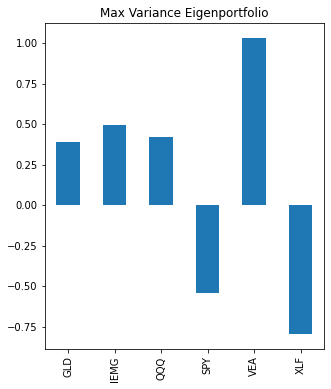

In [132]:
min_risk_eigport = pd.Series(eigvecs[-1], index=df.columns).rename("Weights")
min_risk_eigport.plot(kind="bar", title="Max Variance Eigenportfolio", figsize=(5,6))
plt.show()

### In-Sample Performance

In [133]:
weights = eigvecs[-1]
weights

array([ 0.39254573,  0.49503908,  0.41852637, -0.54086771,  1.03317523,
       -0.79841869])

In [134]:
def get_performance(weights):
    portfolio_log_returns = log_returns.dot(weights)
    eigport_pnl = portfolio_log_returns.cumsum().rename("Max Variance EigPort")
    individual_pnl = log_returns.cumsum(axis=0)
    equal_weight_pnl = log_returns.mean(axis=1).cumsum().rename("Equal Weight")
    performance = pd.concat([eigport_pnl, individual_pnl, equal_weight_pnl], axis=1)
    return performance

perf = get_performance(weights)

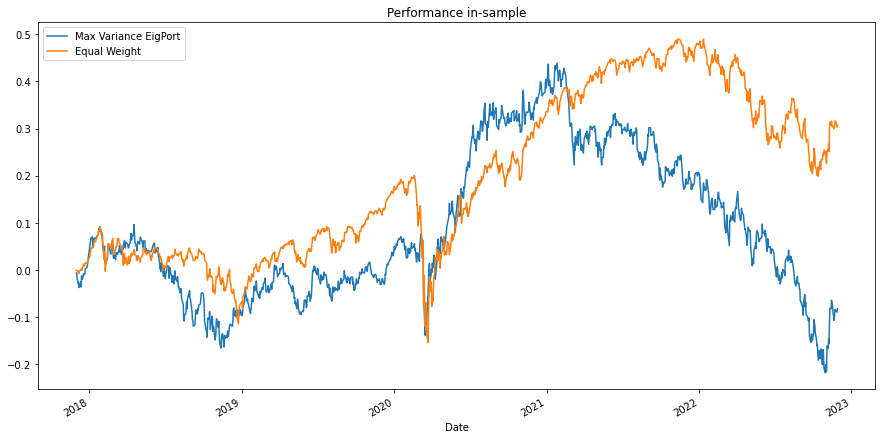

In [135]:
perf[["Max Variance EigPort","Equal Weight"]].plot(title="Performance in-sample", figsize=(15,7.5))
plt.show()

### Speeding things up with eigensolvers

In practice, we are only looking for the maximum/minimum eigenvector of the covariance matrix. In fact, we don't even need to know what the eigenvalues are! 
So is there really a need to compute ```np.linalg.eigh```?
- ```np.linalg.eigh``` computes all eigenpairs of our symmetric matrix using the LAPACK ```syevd``` routine, which either uses a divide-and-conquer or QR algorithm
- In either case, Householder reflections must be computed, which takes $O(m^3)$ flops

In the below code I will try and find out if using (Inverse) Power Iteration can compute the eigenvector associated with the max/min eigenvalue faster than the numpy API
- We will attempt to obtain the dominant eigenvector via Power Iteration

In [142]:
@njit
def rayleigh(A, x):
    # rayleigh quotient to estimate eigenvalue
    eigval = (x.T @ A @ x) / x.T.dot(x)
    return eigval


@njit
def power_iteration(A: np.array, tol: float=0.0001):
    m,n = A.shape

    # initial unit vector guess
    x = np.random.rand(n) / np.sqrt(n)
    eigval = rayleigh(A, x)
    prev_eigval = np.inf

    while np.abs(prev_eigval - eigval) > tol: 
        x = A @ x
        x = x / np.linalg.norm(x)
        prev_eigval = eigval
        eigval = rayleigh(A, x)

    return eigval, x

@njit
def eigh(A:np.array):
    return np.linalg.eigh(A)

lamb, eigvec = power_iteration(cov.to_numpy()) # we get the correct eigenvalue

In [145]:
weights = __normalise_weights(eigvec)

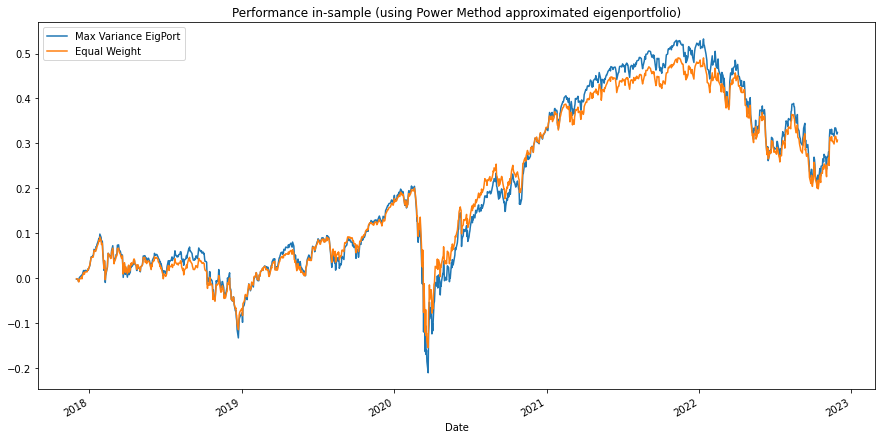

In [146]:
perf = get_performance(weights)
perf[["Max Variance EigPort","Equal Weight"]].plot(title="Performance in-sample (using Power Method approximated eigenportfolio)", figsize=(15,7.5))
plt.show()

### Note

While we are able to solve for the dominant eigenvalue, we don't get the same eigenvector/eigenportfolio as when we call ```np.linalg.eigh``` on the covariance matrix. This is because although symmetric matrices have orthogonal eigenvectors for distinct eigenvalues, the same eigenvalue can obviously have multiple different eigenvectors. This explains the difference in eigenportfolio weights and hence the difference in performance.

### Time Comparison

As shown with ```timeit```, the Power Iteration method is significantly faster. This is of course expected: Calculating a single eigenvalue is obviously faster than solving for all of them.

In [139]:
%timeit power_iteration(cov.to_numpy())

3.37 µs ± 52.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [140]:
%timeit eigh(cov.to_numpy())

7.45 µs ± 183 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
